[1.e+03 1.e+05 1.e+01 1.e+04]
# injected spikes/trial:  16
16.016
[26 16 17 20 22 24 24 25 22 20 34 26 21 21 17 23 20 15 25 20 29 17 31 16
 17 23 29 22 25 24 26 27 24 24 23 29 22 26 19 26 27 19 21 29 23 29 17 24
 22 23 22 19 26 17 24 22 27 18 28 23 19 28 29 23 25 21 25 24 17 24 31 21
 25 22 24 20 15 23 28 24 28 13 26 25 19 27 26 22 20 30 29 34 29 21 19 19
 21 26 24 23 20 19 25 20 24 29 20 28 26 27 23 24 23 22 22 21 31 23 29 26
 18 21 28 24 24 22 20 25 22 20 22 22 19 26 32 35 20 21 29 26 24 29 31 19
 29 26 21 24 22 22 17 28 26 20 30 26 29 21 20 28 20 23 21 24 22 21 22 19
 25 27 24 37 20 39 28 24 23 18 26 33 34 16 19 25 16 19 25 18 19 17 22 22
 13 22 26 24 24 22 23 21 22 18 19 25 17 24 22 23 32 21 23 32 22 30 17 27
 22 28 22 23 29 19 25 19 21 23 23 28 29 29 20 20 21 22 24 24 20 21 22 24
 27 16 26 20 28 21 24 14 17 26 17 22 19 18 14 19 21 22 26 17 18 24 21 23
 21 27 26 22 26 22 30 18 29 18 23 23 21 17 19 15 24 27 17 21 29 24 38 19
 25 12 22 24 17 23 26 22 23 25 28 17 19 19 27 28 21 23 22 

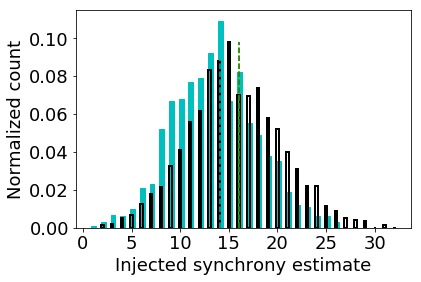

In [39]:
'''
(1) Load a collection of spike train pairs.
(2) Inject synchronous spikes onto each pair of spike trains at random times.
(3) Estimate the amount of injected synchronies.
'''

#------------------------------------------------------------------------------
# Imports
#------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from ccg import correlograms

#------------------------------------------------------------------------------
# Define Functions
#------------------------------------------------------------------------------

def compthta(Rtemp,Ttemp,delta): # function for computing estimate
    Sobs = len(np.intersect1d(Rtemp,Ttemp))
    mxSpk = np.max(np.append(Rtemp,Ttemp))
    bEdges = np.arange(0,mxSpk,10)
    bo = histc(Rtemp, bEdges) 
    refCounts = np.append(bo[0],0)
    w = np.floor(Ttemp/delta)
    Nr = refCounts[w.astype('int')]
    Nr = Nr[Nr!=0]/delta
    naive = Sobs - np.sum(Nr)
    thtahat = naive/(1-((1/len(Nr))*np.sum(Nr)))
    return thtahat

def histc(X, bins): # same functionality as Matlab's histc
    map_to_bins = np.digitize(X,bins)
    r = np.zeros(bins.shape)
    for i in map_to_bins:
        r[i-1] += 1
    return [r, map_to_bins]

def PoissonProcess(intensity,duration,N): # method 1 for injecting spikes
    count = np.random.poisson(lam=intensity,size=N)
    u = np.random.uniform(0,1,size=np.sum(count))
    c = np.int64(np.append(np.zeros(1),np.cumsum(count)))
    T = []
    tag = []
    ind_pos = np.nonzero(count)[0]
    for i in ind_pos:
        T.extend(duration*np.sort(u[c[i]:c[i+1]]))
        tag.extend(i*np.ones(count[i]))
    T = np.asarray(T)
    tag = np.asarray(tag)
                 
    return T,tag

def GenerateInject(train,Ntrial,duration,synch_width,inject_count): # method 2 for injecting spikes
    Nwidth = int(duration/synch_width)
    allwidths = np.arange(int(Ntrial*duration/synch_width))
    include_index = np.int64(np.floor(train0/synch_width))
    include_idx = list(set(include_index)) 
    mask = np.zeros(allwidths.shape,dtype=bool)
    mask[include_idx] = True
    wheretoinject = synch_width*allwidths[~mask]
    alreadythere = synch_width*allwidths[mask]
    widths = np.append(wheretoinject,alreadythere)
    tags = np.append(np.zeros(len(wheretoinject)),np.ones(len(alreadythere)))
    ind_sort = np.argsort(widths)
    widths = widths[ind_sort]
    tags = tags[ind_sort]
    widths = widths[:Ntrial*Nwidth]
    tags = tags[:Ntrial*Nwidth]
    widths = np.reshape(widths,(Ntrial,Nwidth))
    tags = np.reshape(tags,(Ntrial,Nwidth))
    ind_perm = np.int64(np.transpose(np.random.permutation(np.mgrid[:Nwidth,:Ntrial][0]))) 
    widths = widths[np.arange(np.shape(widths)[0])[:,np.newaxis],ind_perm]
    tags = tags[np.arange(np.shape(tags)[0])[:,np.newaxis],ind_perm]
    ind_sort = np.argsort(tags,axis=1)
    widths = widths[np.arange(np.shape(widths)[0])[:,np.newaxis],ind_sort]
    tags = tags[np.arange(np.shape(tags)[0])[:,np.newaxis],ind_sort]
    train_inject = np.ravel(widths[:,:inject_count])
    
    return train_inject

#------------------------------------------------------------------------------
# Load spike data
#------------------------------------------------------------------------------

train_ref0 = np.load('train_ref_range.npy')   # Collection of reference spike trains
train_targ0 = np.load('train_targ_range.npy') # Collection of target spike trains
params = np.load('parameters_range.npy')          
Ntrial = int(params[0])                   # Number of trials
duration = params[1]                     # Trial duration in (ms)
period = params[2]                       # Nonstationarity timescale in (ms)
Fs = params[3]

print(params)

train0 = np.append(train_ref0,train_targ0)
cell0 = np.int64(np.append(np.zeros(len(train_ref0)),np.ones(len(train_targ0))))

#------------------------------------------------------------------------------
# Inject synchronous spikes
#------------------------------------------------------------------------------

synch_width = 1.                                   # Width of synchrony window in (ms)
Tref0 = synch_width*np.floor(train_ref0/synch_width)  # Discretize reference trains
Ttarg0 = synch_width*np.floor(train_targ0/synch_width)# Discretize target trains
Tsynch0 = np.array(list(set(Tref0) & set(Ttarg0)))    # Compute reference-target synchronies' time
synch_count0 = np.bincount(np.int64(np.floor(Tsynch0/duration)),minlength=Ntrial) # Count number of synchronies per trial 

inject_count = int(np.amax(synch_count0))           # Amount of injected synchronies
print("# injected spikes/trial: ",inject_count)
Nwidth = int(duration/synch_width)                 # Number of synchrony windows in 

train_inject, label_inject = PoissonProcess(inject_count, duration, Ntrial)
train_inject = label_inject*duration + train_inject
print(len(train_inject) * 1. / Ntrial)

train_ref = np.sort(np.append(train_ref0,train_inject))
train_targ = np.sort(np.append(train_targ0,train_inject)) 

train = np.append(train_ref,train_targ)
cell = np.int64(np.append(np.zeros(len(train_ref)),np.ones(len(train_targ))))

# Synchrony cout distribution after injection
synch_width = 1.
Tref = synch_width*np.floor(train_ref/synch_width)
Ttarg = synch_width*np.floor(train_targ/synch_width)
Tsynch = np.array(list(set(Tref) & set(Ttarg)))
synch_count = np.bincount(np.int64(np.floor(Tsynch/duration)),minlength=Ntrial)
print(synch_count,'s')

# Predict the amount of injected synchrony in each trial segment
Tind = np.floor(train_targ/Dur)
Rind = np.floor(train_ref/Dur)
for k in range(np.max(Tind).astype('int')):
    TT = train_targ[Tind==k]
    RR = train_ref[Rind==k]
    injection_unbiased = np.append(injection_unbiased,compthta(np.round(RR),np.round(TT),interval))
    Rcard = np.append(Rcard,RR)

# Plot  
FigTh = plt.figure()
plt.xlabel('Injected synchrony estimate',fontsize=18)
plt.ylabel('Normalized count',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
bins = np.arange(np.amin(injection_naive),np.amax(injection_naive),1)
count,base = np.histogram(injection_naive,bins=bins,density=1)
X = base[:-1]
plt.bar(X,count,width=.5,align='center',color='c',edgecolor='c')
plt.plot(np.mean(injection_naive)*np.ones(2),[0,np.amax(count)],'--c')
bins = np.arange(np.amin(injection_unbiased),np.amax(injection_unbiased),1)
count,base = np.histogram(injection_unbiased,bins=bins,density=1)
X = base[:-1]
plt.bar(X,count,width=.25,align='center',color='None',edgecolor='k',linewidth=2)
plt.plot(np.mean(injection_unbiased)*np.ones(2),[0,np.amax(count)],'--y')
plt.plot(inject_count*np.ones(2),[0,np.amax(count)],'--g')
plt.show() 